# Boston Housing Modelling

In this notebook will be performed an exploratory data analysis (EDA) on the famous Boston housing dataset and, based on the findings a regression model will be created and refined using TensorFlow and the Keras API

```
The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
 prices and the demand for clean air', J. Environ. Economics & Management,
 vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
 ...', Wiley, 1980.   N.B. Various transformations are used in the table on
 pages 244-261 of the latter.

 Variables in order:
 CRIM     per capita crime rate by town
 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 INDUS    proportion of non-retail business acres per town
 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 NOX      nitric oxides concentration (parts per 10 million)
 RM       average number of rooms per dwelling
 AGE      proportion of owner-occupied units built prior to 1940
 DIS      weighted distances to five Boston employment centres
 RAD      index of accessibility to radial highways
 TAX      full-value property-tax rate per $10,000
 PTRATIO  pupil-teacher ratio by town
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 LSTAT    % lower status of the population
 MEDV     Median value of owner-occupied homes in $1000's
```

In [2]:
# Importing the libraries and checking TF version for compatibility
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objs as go
import plotly.express as px
print(tf.__version__)

2.5.0


## Checking Hardware Configuration

Checking if TF has recognized the local GPU that will be used for training the model

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Mon May 31 21:23:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.47       Driver Version: 466.47       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:04:00.0  On |                  N/A |
| 21%   53C    P5    18W / 125W |   1346MiB /  6144MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading the dataset from TF

In [5]:
# Getting the data without train test split to conduct initial analysis of whole data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=0, seed=113
)
COLUMNS = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']     
len(x_train)

506

In [6]:
# Joining both the features and the results to analyze
x = pd.DataFrame(x_train,columns=COLUMNS[:-1])
y = pd.DataFrame(y_train,columns=COLUMNS[-1:])
x['MEDV'] = y
# Getting the basic statistical info from DataFrame
x.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Exploratory Analysis

The first thing to be noticed is that the target has a very normalised behaviour (Kurtosis = 1.5 and Skewness = 1.11)
- [ ] Determine if the higher frequency for value 50 is expected behaviour or has some kind of problem



### Testing out D-Tale

D-Tale is a tool to ease the EDA process, whilst still retaining the ability to export the most useful graphs and data to python code to keep them directly on the notebook.

In this project it will be used to better understand the behaviour of the variables and target and, afterwards use SweetViz to deepen the dependance analysis and validate the train/test split.

In [7]:
import dtale

d = dtale.show(x)
d._url
d

### Analysing the target value

Analysing the target value histogram and boxplot we can determine that the distribution has close to normal behaviour, with a little noise on the tail caused by multiple distinct values having their price set as 50.

In the next steps this possibly anomalous behaviour will be analysed based on other variables behaviour in order to determine how to deal with it.

In [8]:
# Plotting the target variable histogram
df = x
s = df[~pd.isnull(df['MEDV'])][['MEDV']]
chart, labels = np.histogram(s, bins=20)
import scipy.stats as sts
kde = sts.gaussian_kde(s['MEDV'])
kde_data = kde.pdf(np.linspace(labels.min(), labels.max()))
# main statistics
charts = [
	go.Bar(x=labels[1:], y=chart, name='Histogram'),
	go.Scatter(
		x=list(range(len(kde_data))), y=kde_data, name='KDE',yaxis='y2', xaxis='x2',line={'shape': 'spline', 'smoothing': 0.3}, mode='lines'
	)
]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'MEDV Histogram (bins: 20) w/ KDE'},
    'xaxis2': {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
    'yaxis': {'side': 'left', 'title': {'text': 'Frequency'}},
    'yaxis2': {'overlaying': 'y', 'side': 'right', 'title': {'text': 'KDE'}}
}))

figure


(count    506.000000
 mean      22.532806
 std        9.197104
 min        5.000000
 25%       17.025000
 50%       21.200000
 75%       25.000000
 max       50.000000
 Name: MEDV, dtype: float64,
 <AxesSubplot:>)

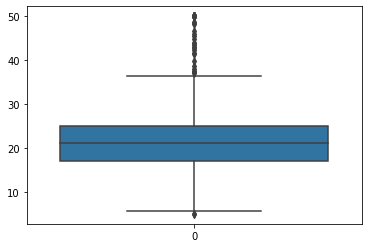

In [9]:
df['MEDV'].describe(), sns.boxplot(data = df['MEDV'])

### Analysing the other features

From the pairplot's histograms we can gather some insights about the data:

* `RM` has a very normalized distribution
* `LSTAT`,`DIS`, `CRIM` and `ZN` are all positively skewed (some moderately and other more aggressively)
* `RAD`, `TAX` seem to have outliers
  * They have a seemingly normal distribution on the lower end and a suspiciously high frequency of cases much higher
  * These higher values doesn't seem to have a clear cause that jutstify them (based on the other variables) and, thus, may be considered as outliers
* `B` Is very negatively skewed
  * This may be caused by the formula which calculates the value on the database (`1000(Bk - 0.63)^2`) in which 0 <= Bk >= 1, since Bk is a percentage
  * This formula is very ambiguous, as a B value of 100 could indicate a Bk = 0.31 or Bk = 0.94 [(Wolfram)](https://www.wolframalpha.com/input/?i=1000%28x+-+0.63%29%5E2+%3D100)
  * Because of this inconsistency this variable can already be discarded as a possible predictor of our model

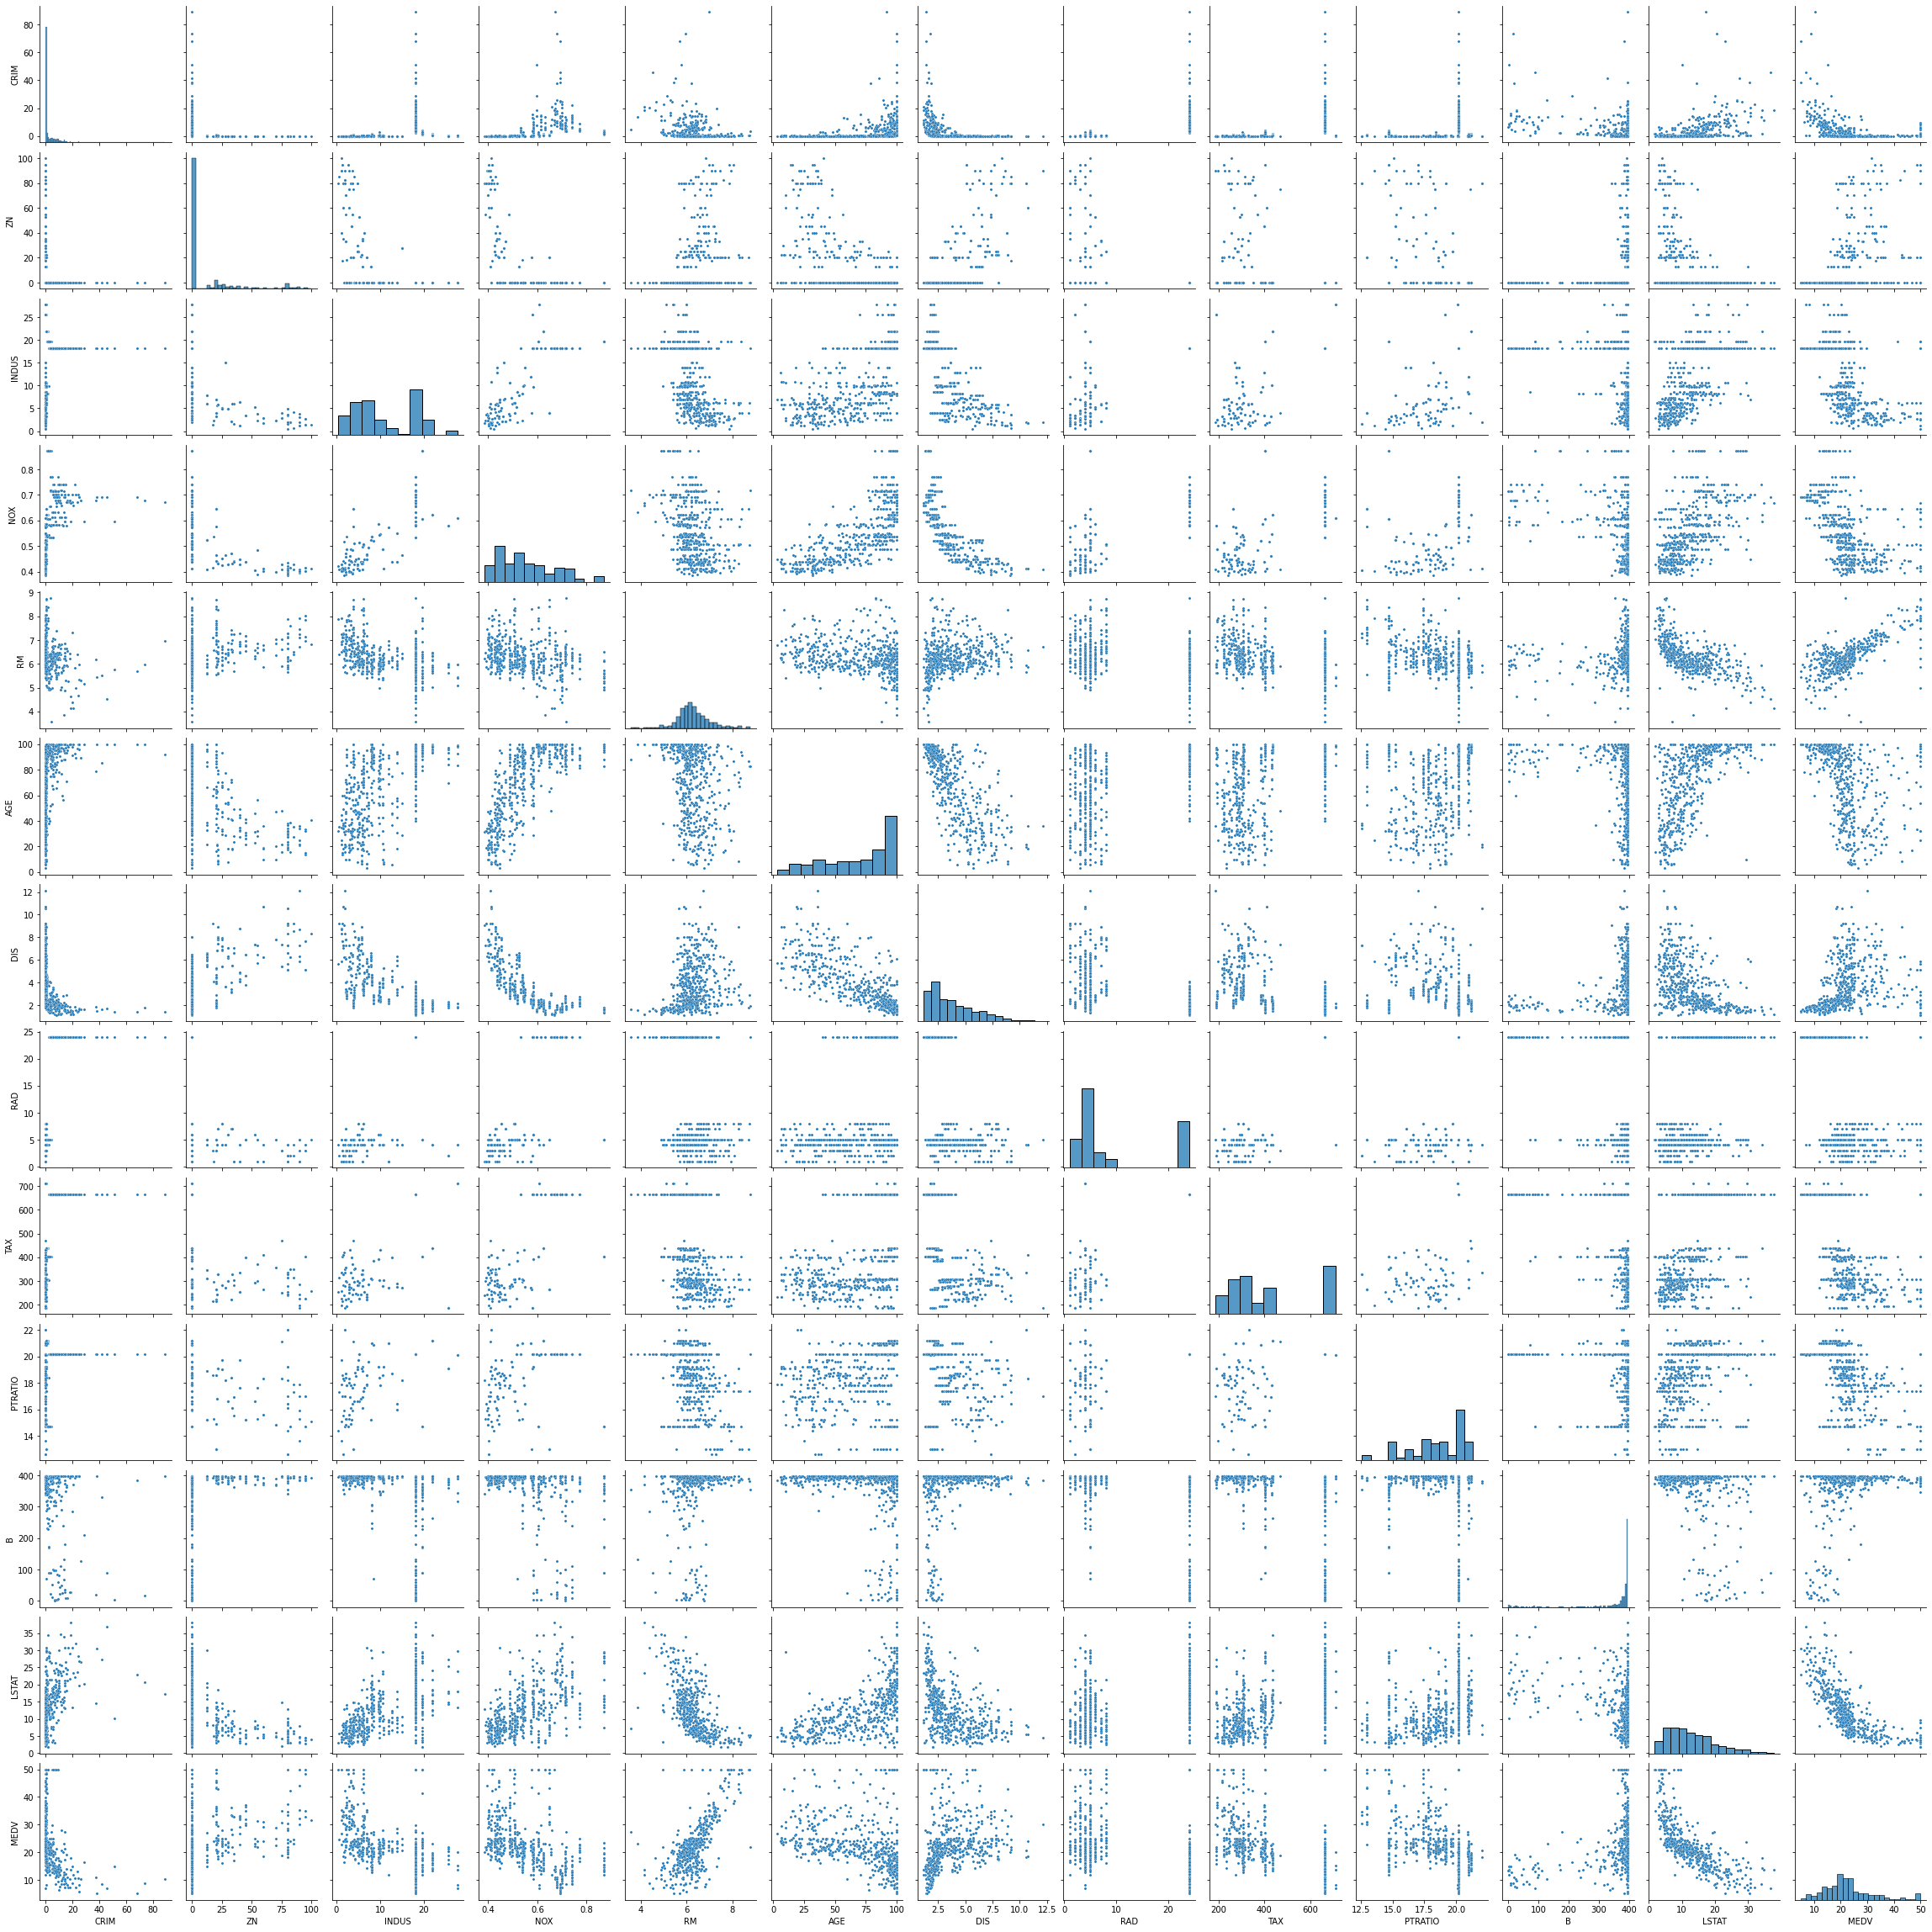

In [10]:
#  CHAS is dropped as it is a dummy variable 
sns.pairplot(x.drop('CHAS',axis = 1),plot_kws={"s": 10})

### Analysing the features relation with our target

The first thing we can notice when analysing the scatter plots + regressions is that no feature justifies the higher frequency of values on the higher end (50) of the target value, so we can attribute this as an error or limitation of the data acquisition method. This data will be discarded before being fed into the model (this is possible since it doesn't represent such a high % of the whole dataset)

Secondly, we can analyse the relationships between our target data and the features, looking for possible predictors. Luckily we seem to have some good candidates.

**Highly Correlated Features (>0.5)**
1. `LSTAT` -> Indicates the percentual value of the population that belongs to the lower income classification
    - Has a high negative correlation with the target value 
    - It's possible to evaluate this correlation as real due to the fact that higher incomes tends to lead to more expensive living conditions (which include housing)
2. `RM` -> # of rooms per house, pretty self-explanatory as more rooms tend to indicate higher-end houses
   - Has a high positive correlation with target data (as expected)
3. `PTRATIO` -> Pupil-teacher ratio, a lower number possibly indicates better schooling infrastructure
    - As is the case with `LSTAT`, this correlation (albeit negative in this case) can be deemed true due to better infrastructure tends to raise the value of properties nearby

**Medium Correlated Features**

1. `INDUS` -> Proportion of non-retail business in area (in other words industrial spaces)
   - Expected negative correlation as more industrialized areas tend to be less valued on the market
2. `NOX` -> This correlation may be explained by the variable above, as places with more industries tend to have more NOx ppm (also noticeable on the scatterplot)
   - Due to this high correlation both can be considered linearly dependent, which means only one should be included on the model
3. `CRIM` -> Expected behaviour (more crime means lower price), although the crime data is heavily skewed towards lower values and not much data points for higher values so this may create a bias on the model due to the inbalance on the dataset
4. `Age` -> Older buildings tend to have lower price when compared to a brand new with similar caracteristics
    - As is the case with `CRIM` this variable has an inbalance towards higher values
5. `RAD` -> Ordinal categorical data, a lower index possibly indicates better accessibility to radial roads, leading to higher prices

**Other Variables**

These variables have low chance of being good predictors, when compared with the ones listed above

1. `ZN` -> The proportion of residential land zoned for lots over 25,000 sq.ft.
    -  Heavily correlated with `DIS`, meaning probably bigger lots on the outskirts of town
    -  More than 70% of the values on this variable are 0, which make it the most unbalanced and reducing its predictability power
2. `TAX` -> 26% of the data points have value 666 which, when analysing the other variables, might indicate errors on the data. Since the dataset is not extensive, removing these points can negatively impact the results of the model
3. `DIS` -> Low correlation (0.25) and heavily correlated with `NOX` and `INDUS`, which we may consider as well as a linear dependency and remove it from the model
4. `CHAS` -> Binary value, heavily inbalanced and with very low correlation. 

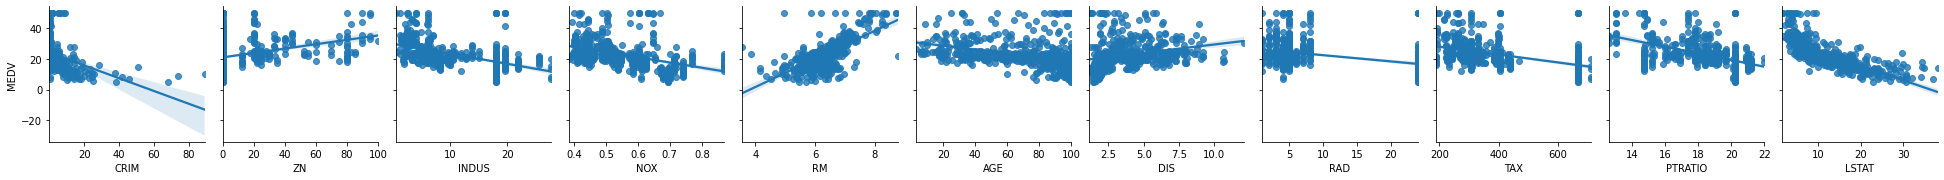

In [11]:
# CHAS ignored as it is a dummy variable
# B is ignored due to the motives highlighted above
sns.pairplot(x, x_vars=x.drop(['MEDV','CHAS','B'],axis = 1).columns,y_vars=['MEDV'], kind='reg')


<AxesSubplot:>

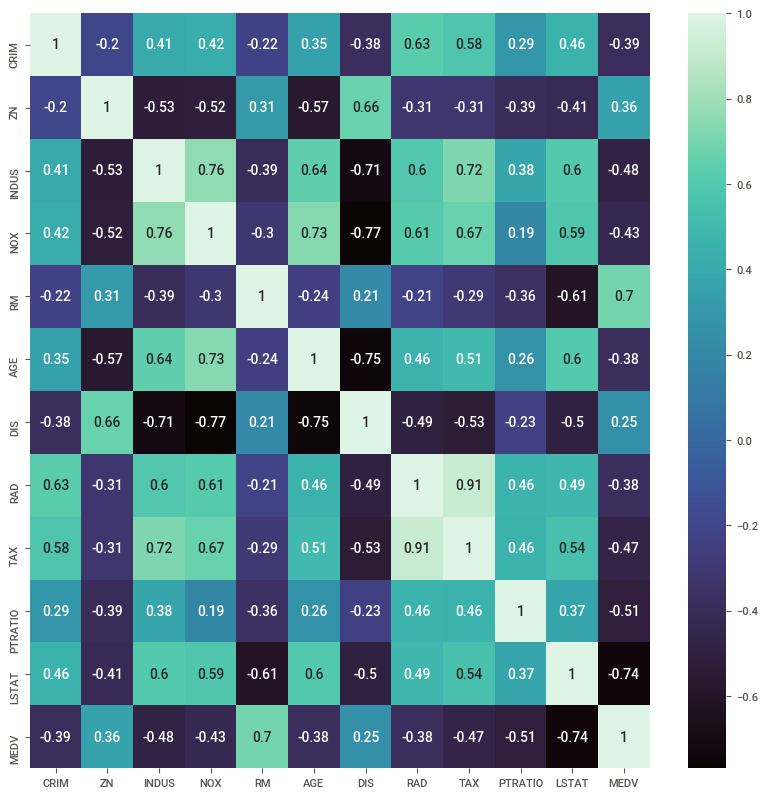

In [ ]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(x.drop(['CHAS','B'],axis = 1).corr(),annot = True,cmap='mako')

<AxesSubplot:xlabel='DIS', ylabel='ZN'>

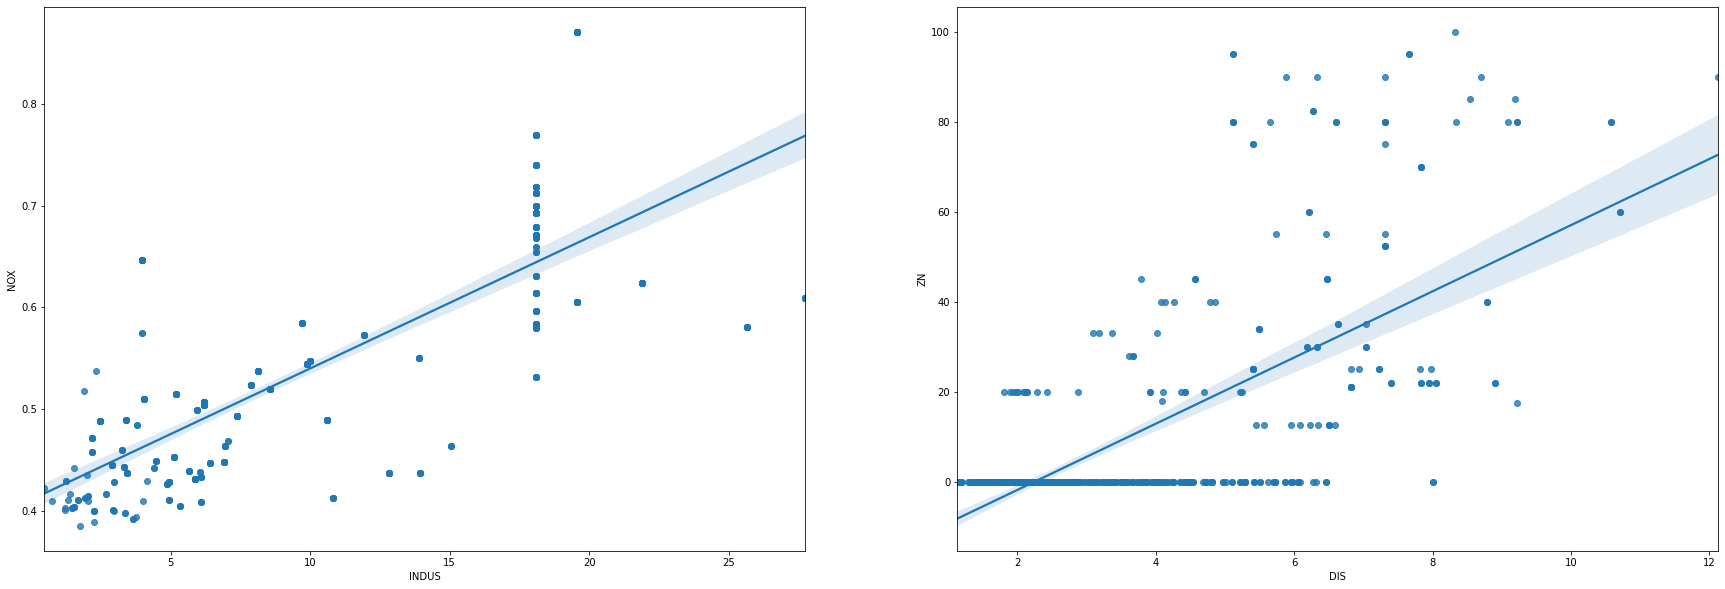

<Figure size 720x720 with 0 Axes>

In [33]:
fig, axs = plt.subplots(ncols=2,figsize = (30,10))
fig = plt.figure(figsize=(10,10))
sns.regplot(data = x, x='INDUS',y = 'NOX',ax = axs[0])
sns.regplot(data = x, x='DIS',y = 'ZN',ax = axs[1])

### Loading data into SweetViz

In [ ]:
import sweetviz as sv

analysis_report = sv.analyze([x,'Boston Housing'], target_feat='MEDV')

[Step 3/3] Generating associations graph     |          | [  0%]   00:00 -> (? left)


Report .\Analysis\Analysis_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



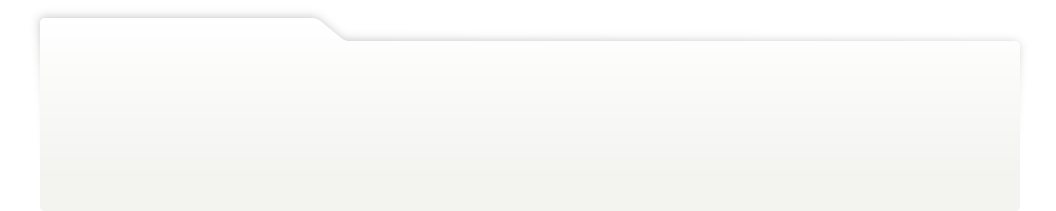
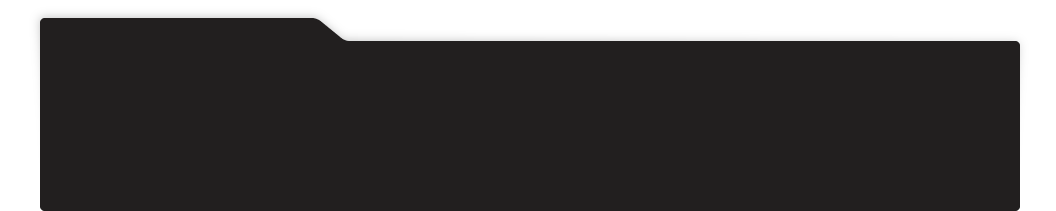
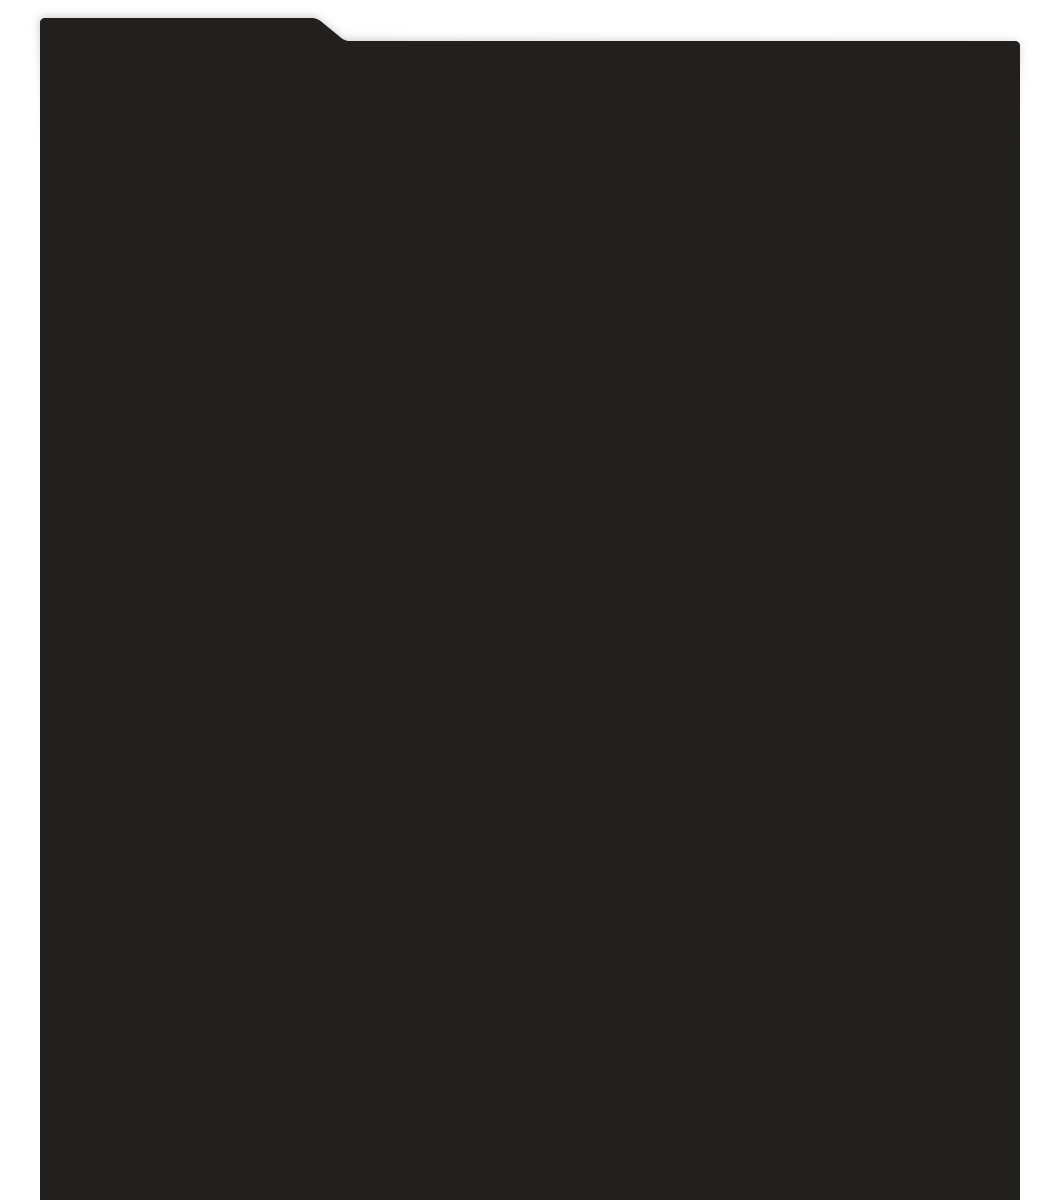
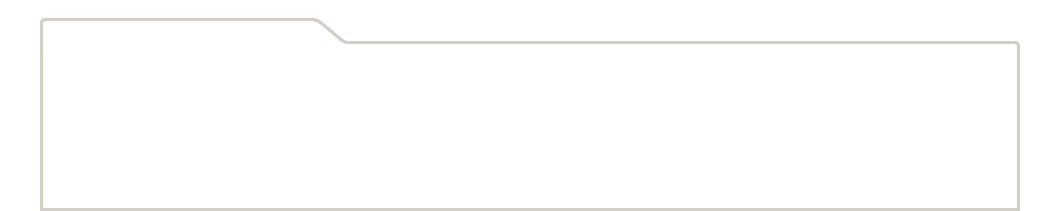
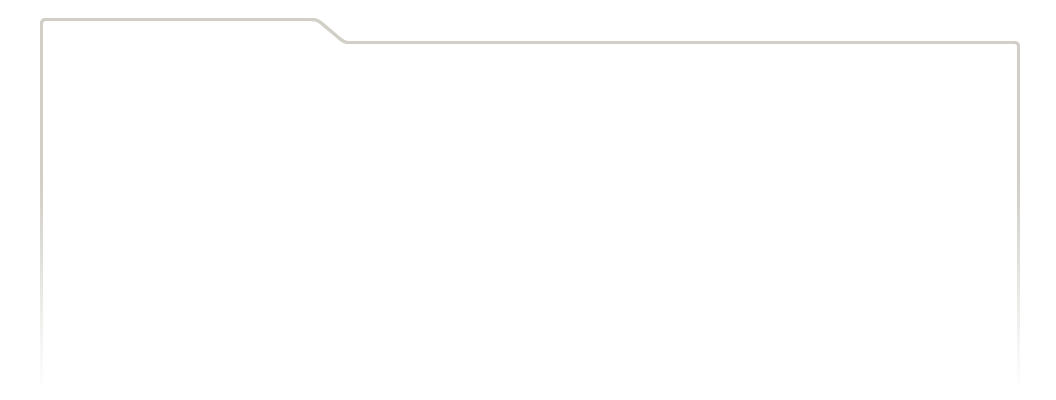
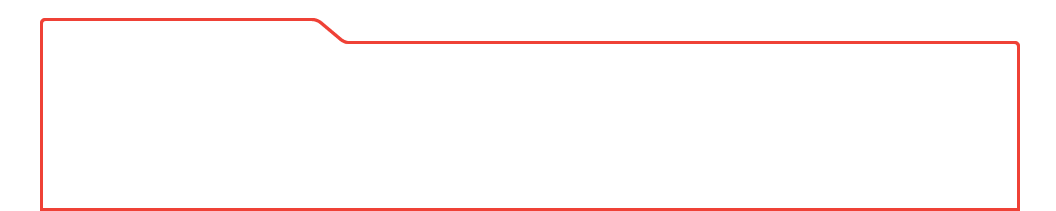
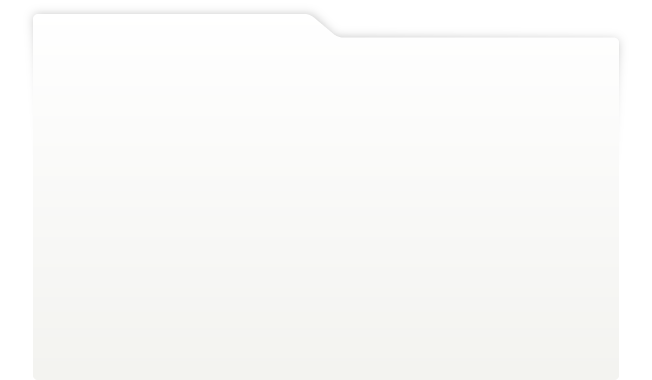
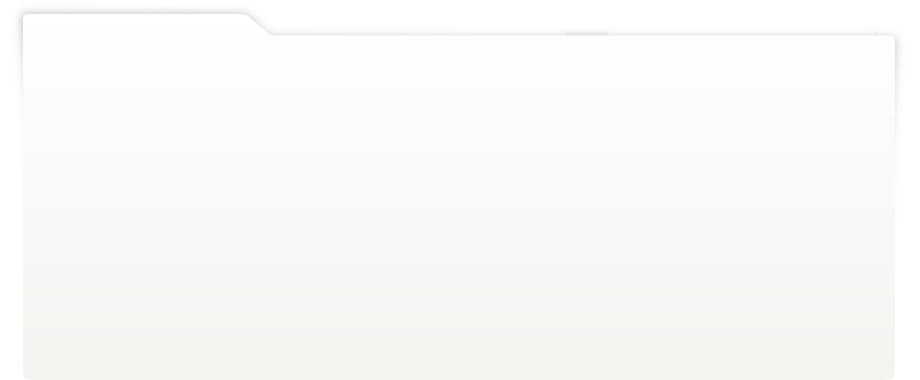
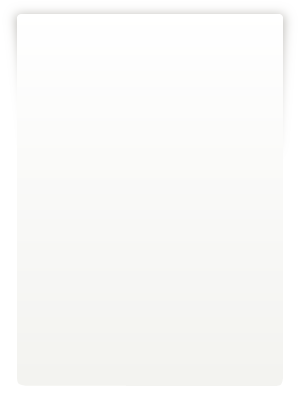
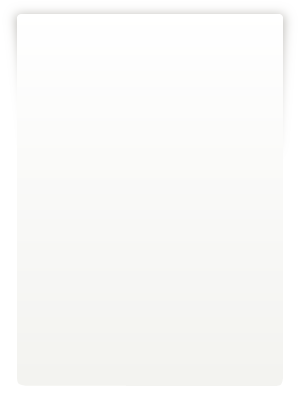
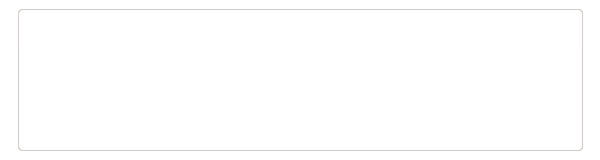
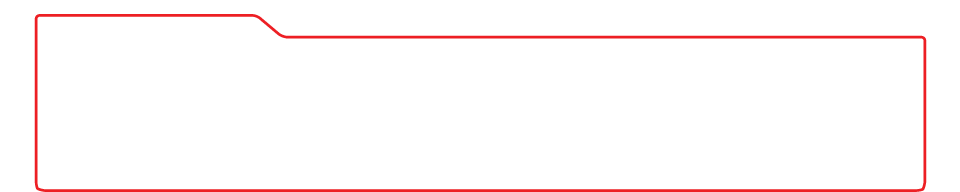
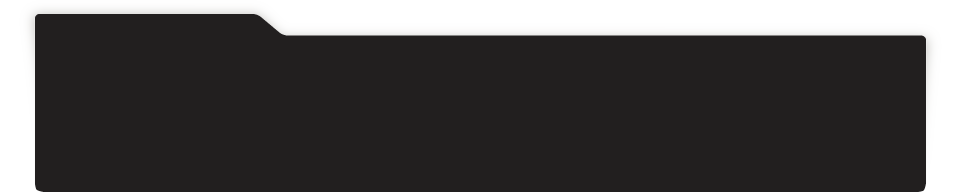
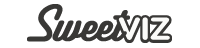
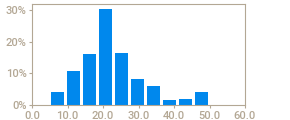
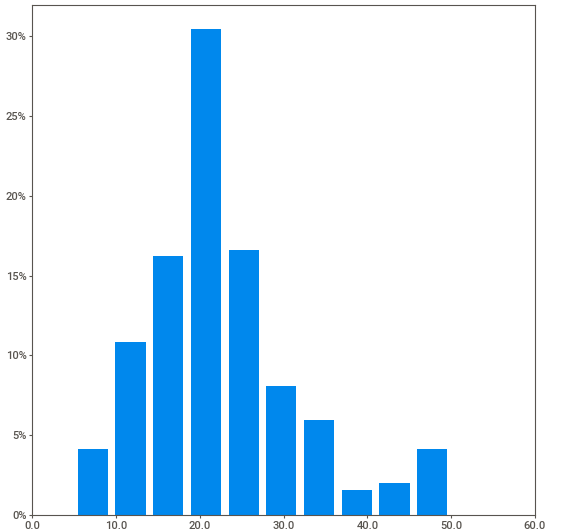
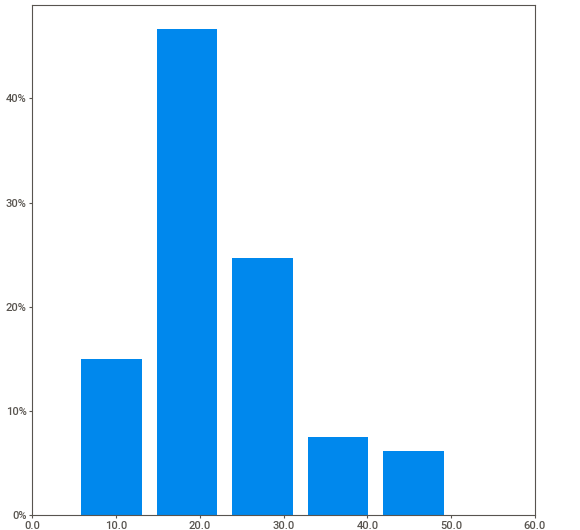
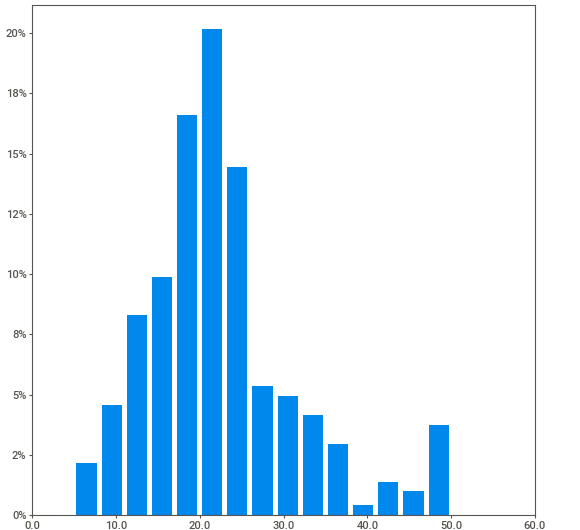
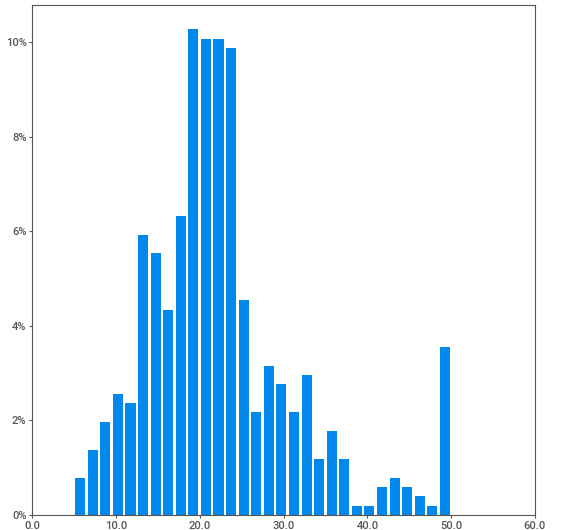
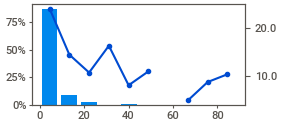
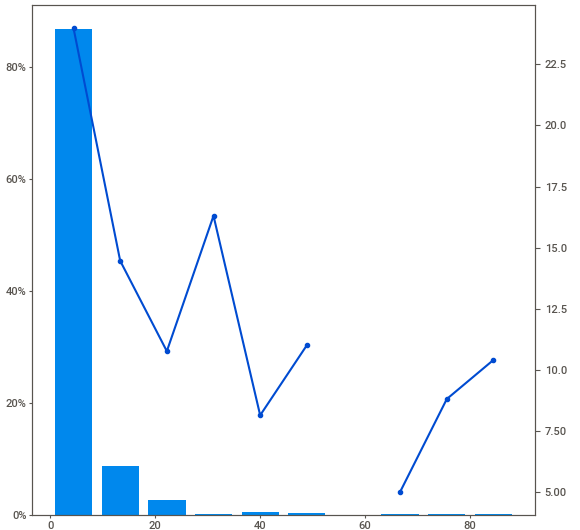
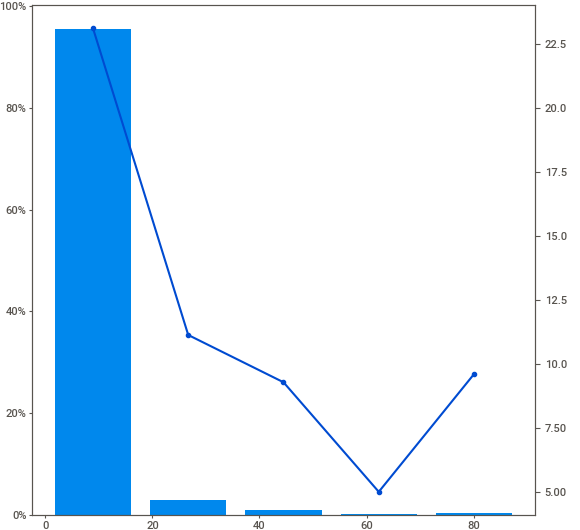
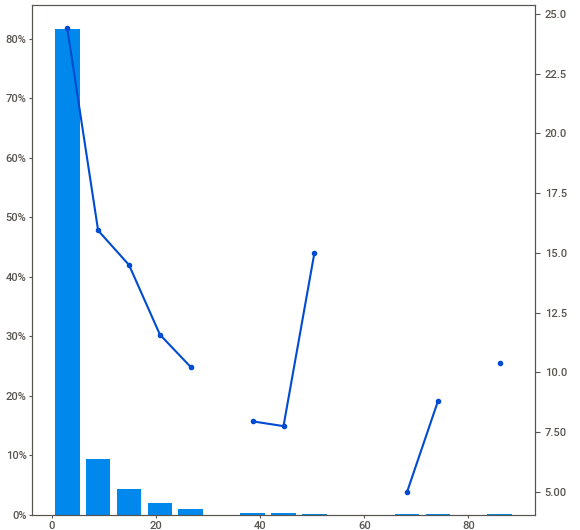
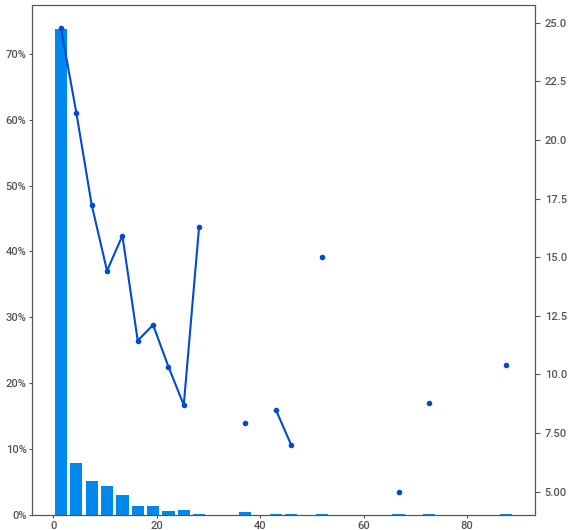
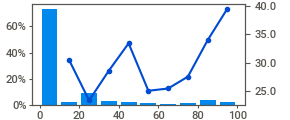
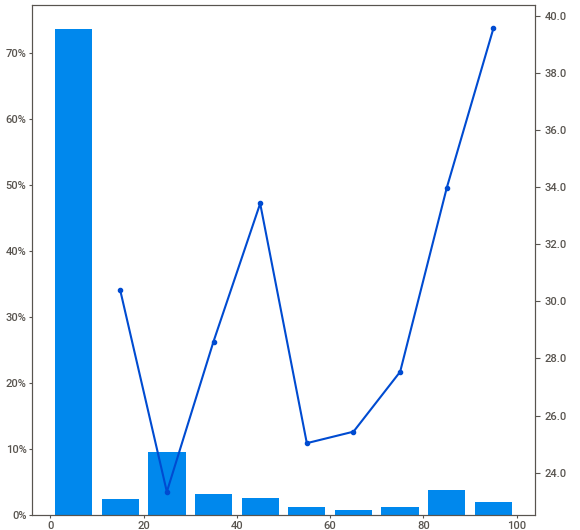
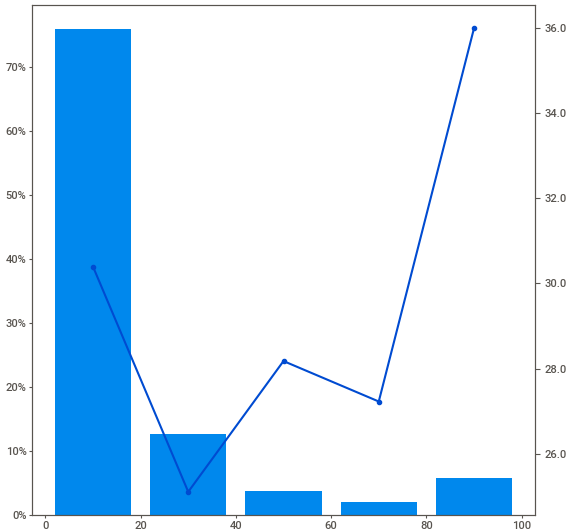
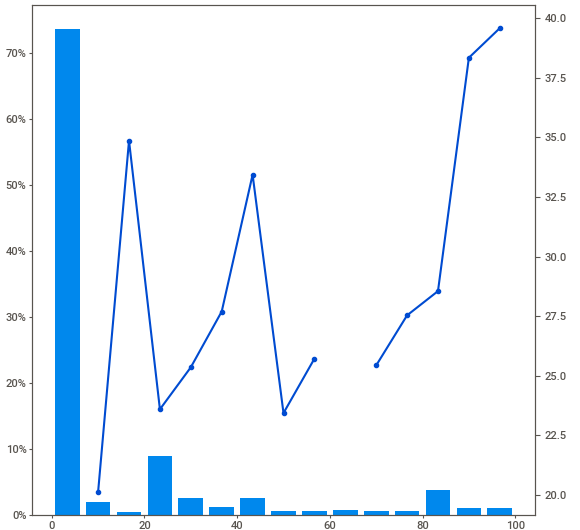
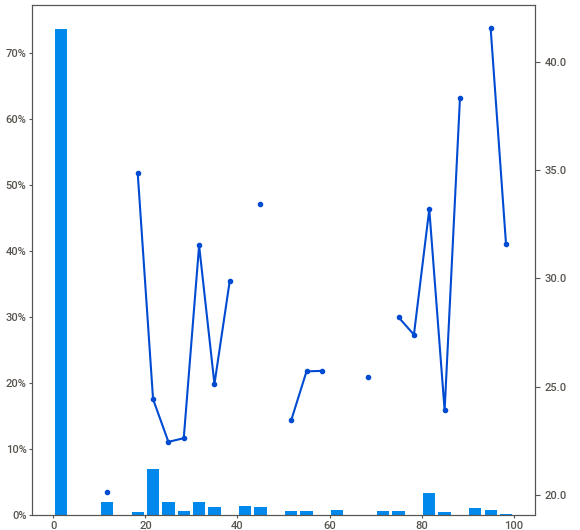
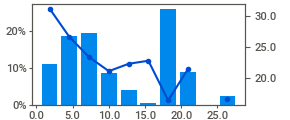
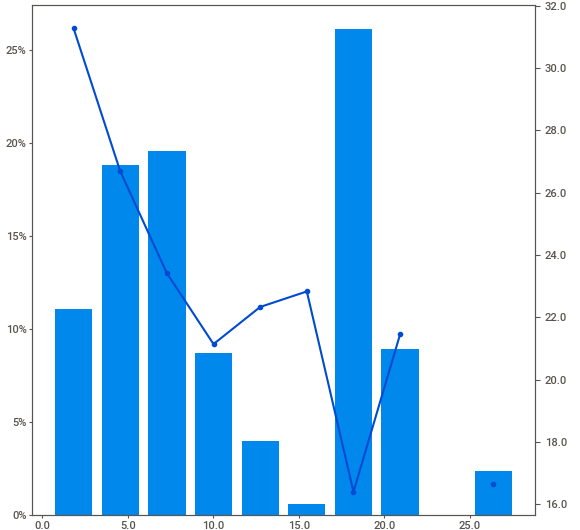
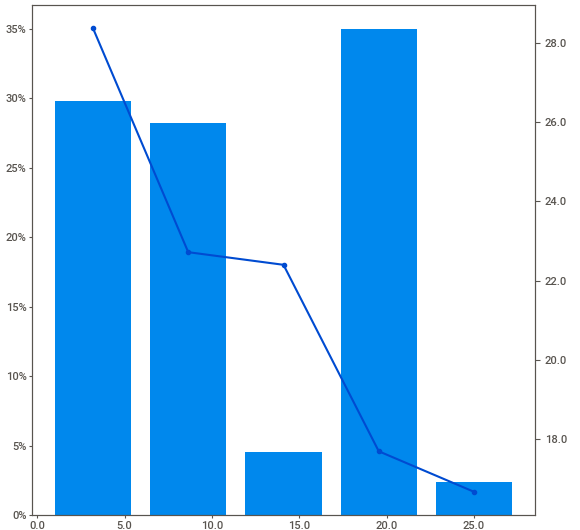
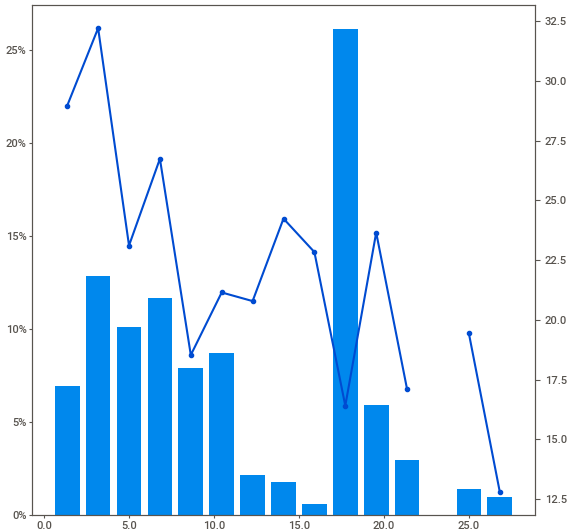
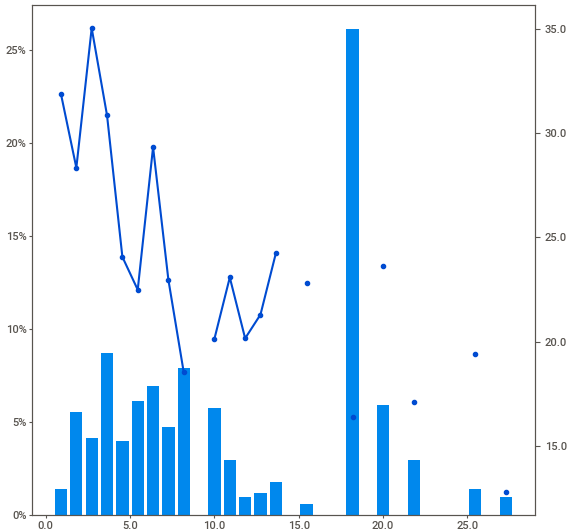
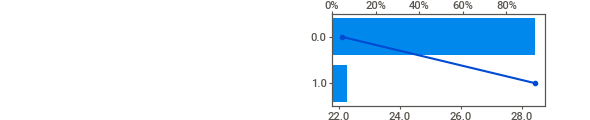
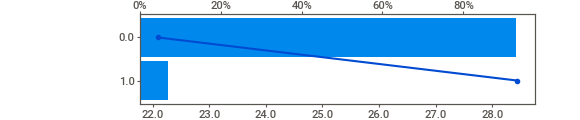
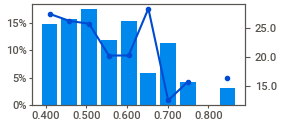
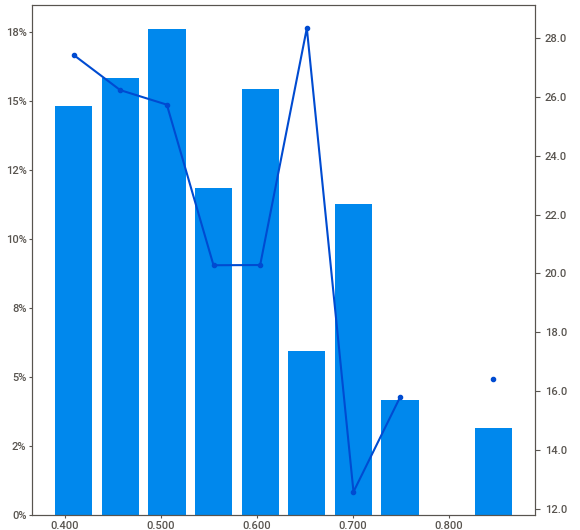
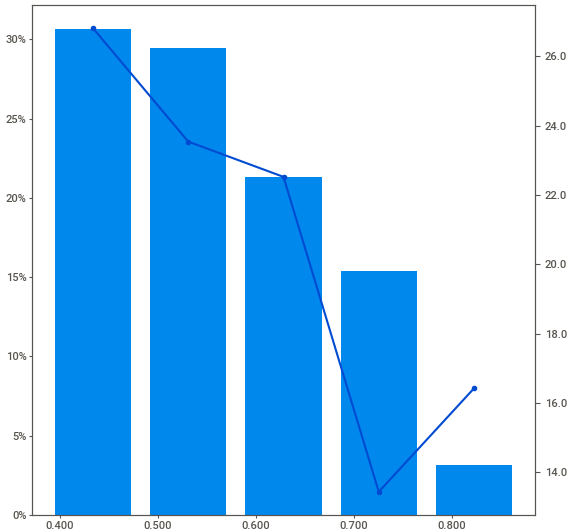
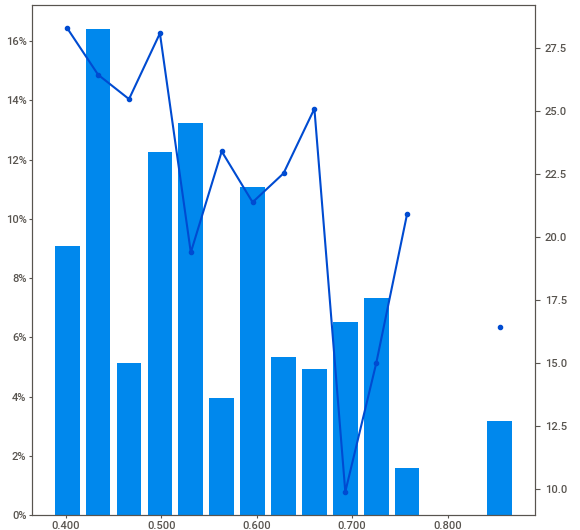
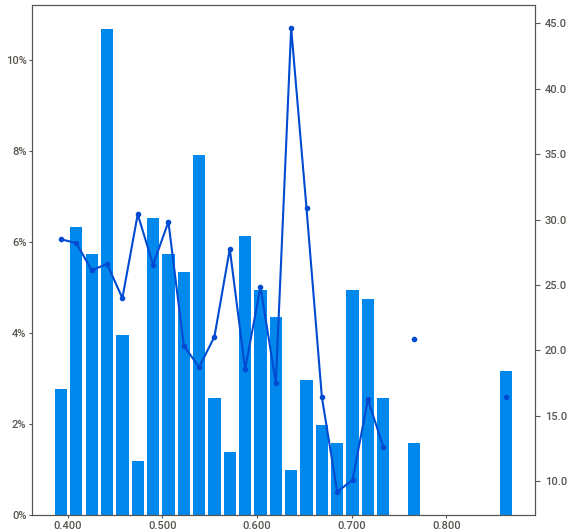
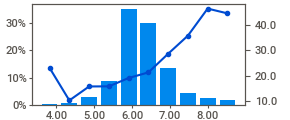
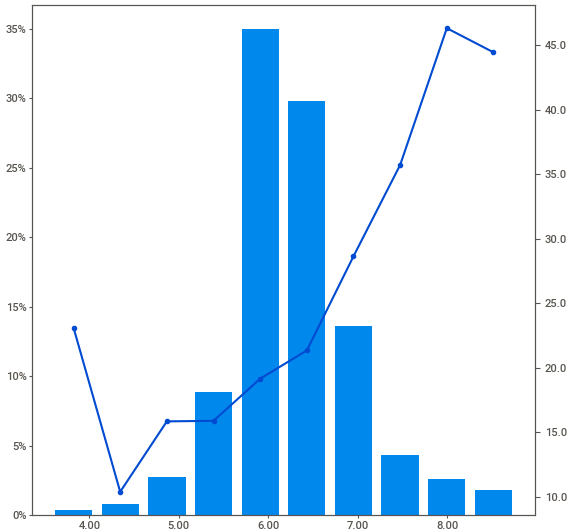
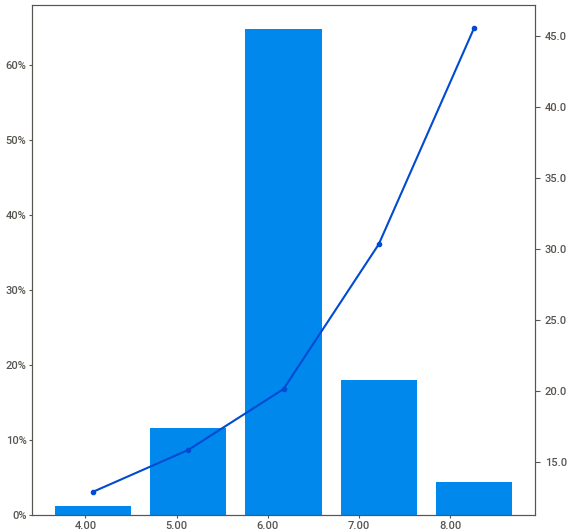
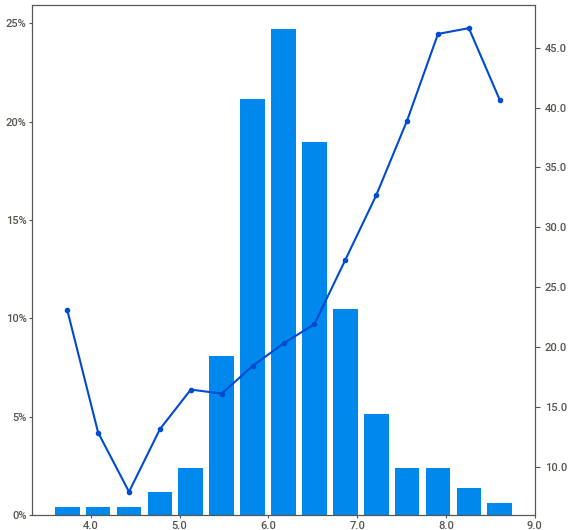
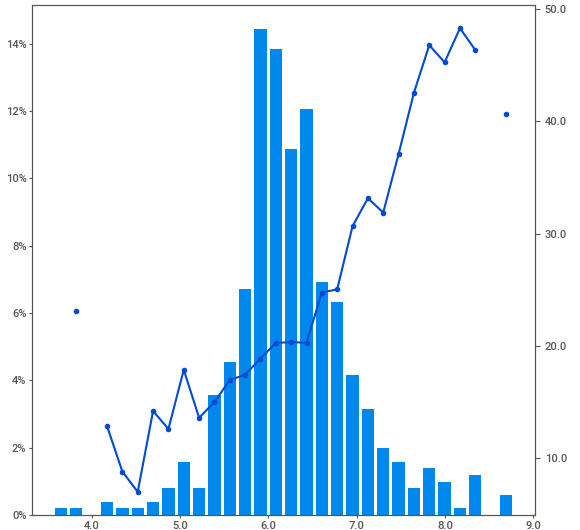
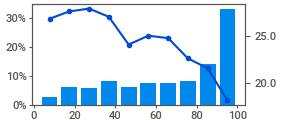
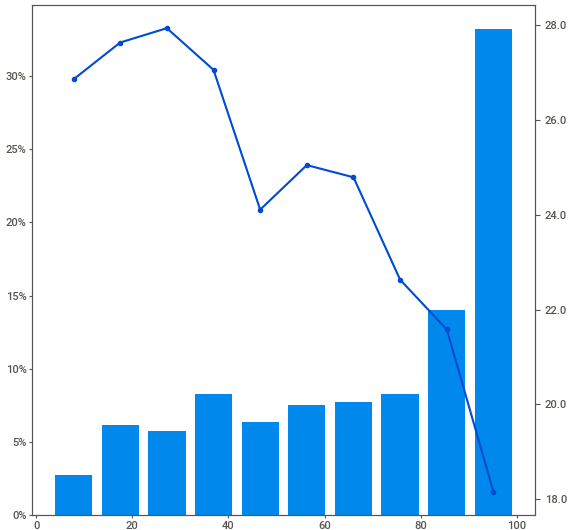
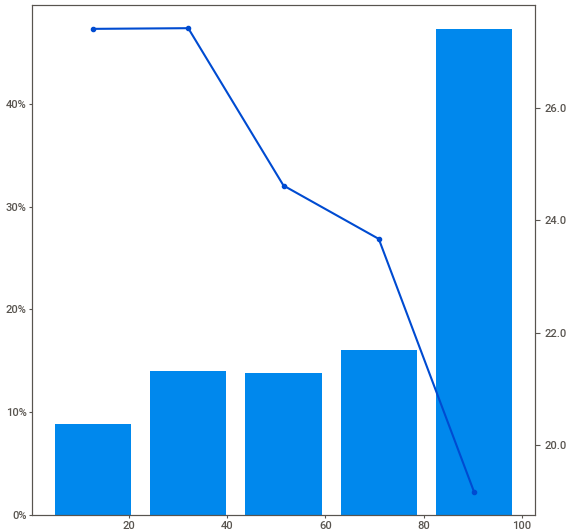
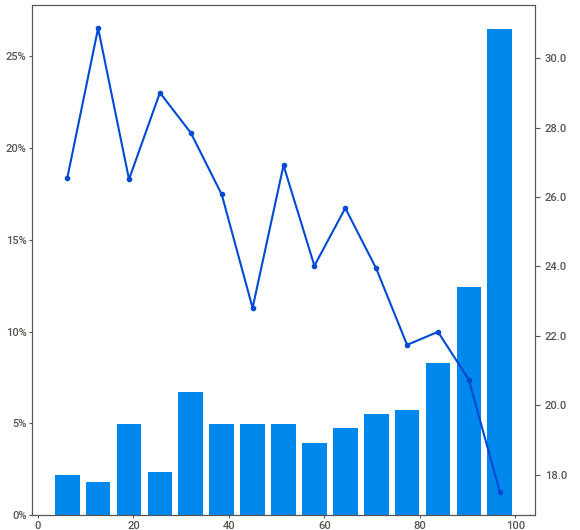
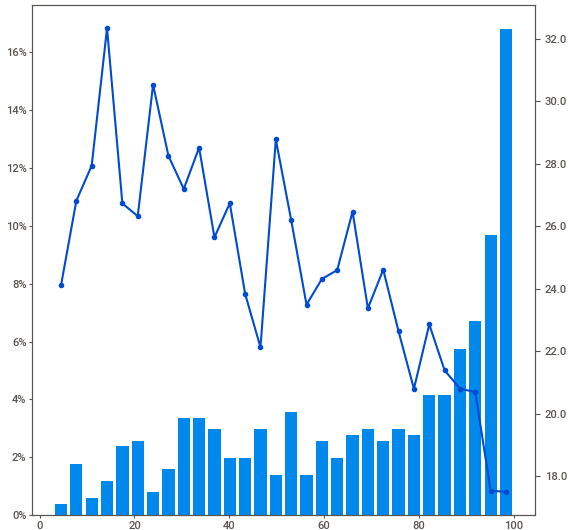
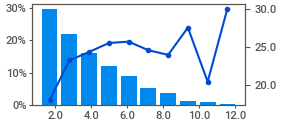
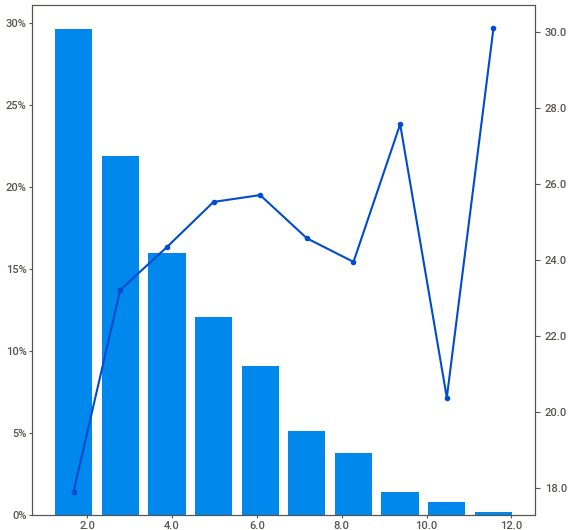
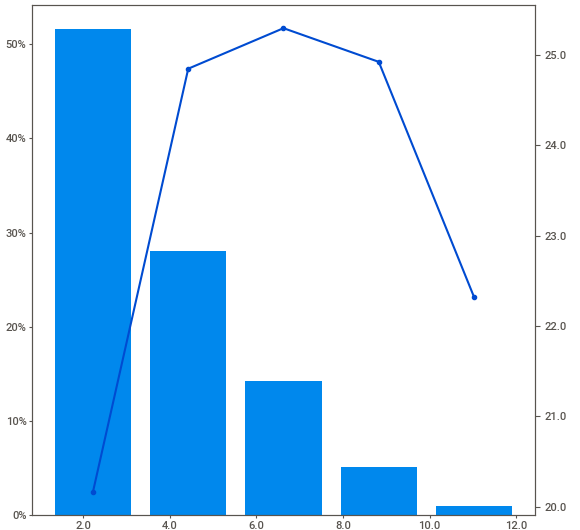
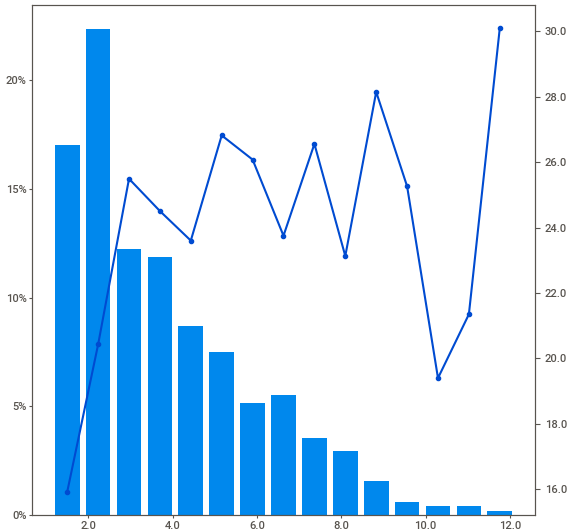
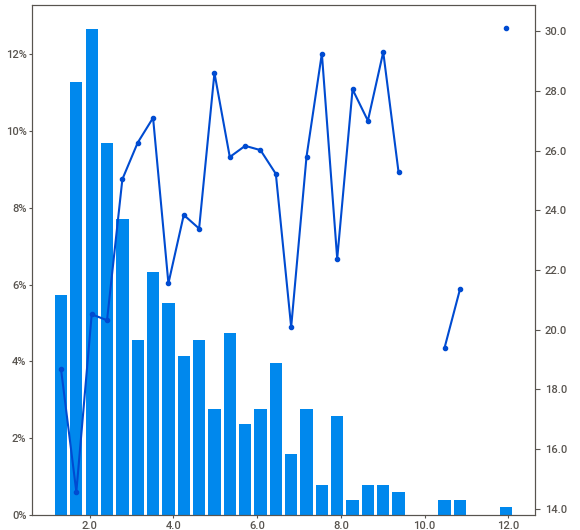
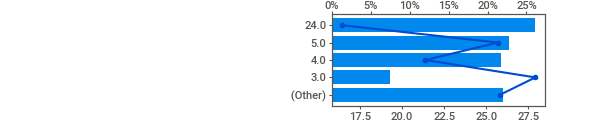
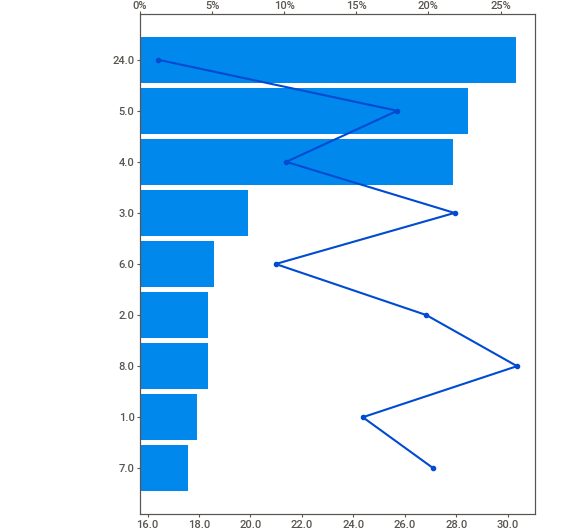
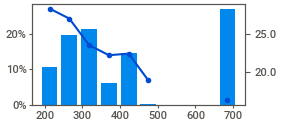
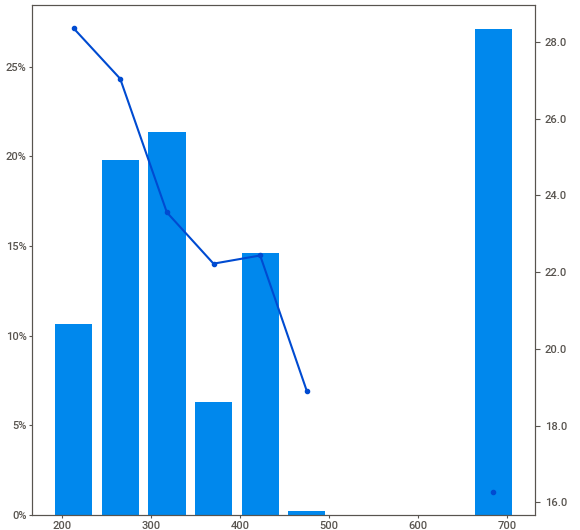
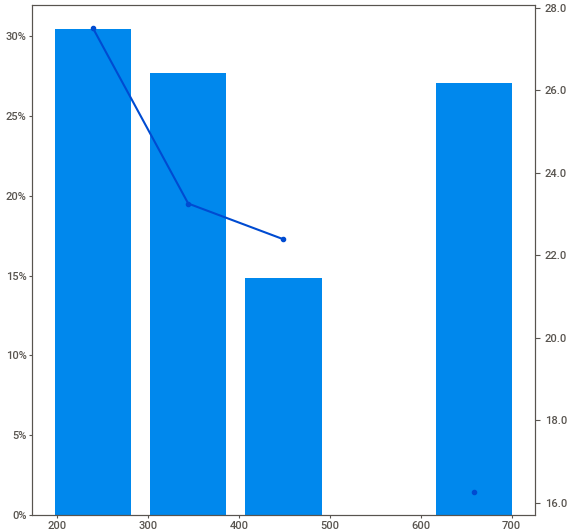
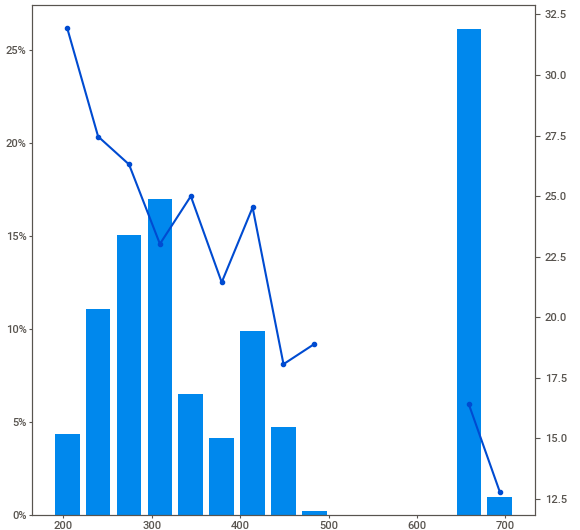
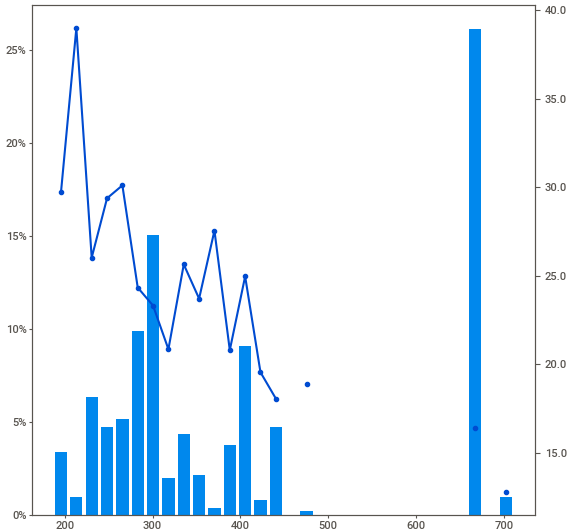
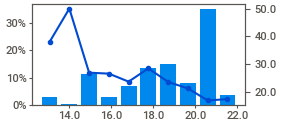
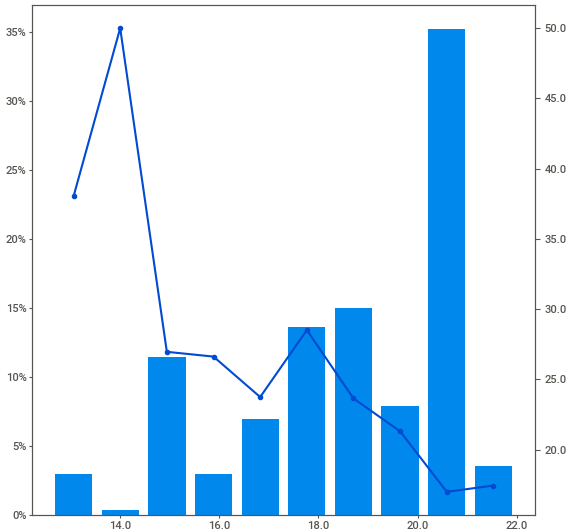
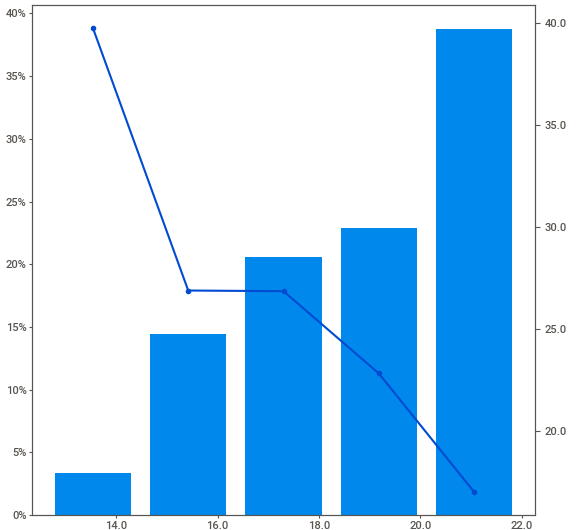
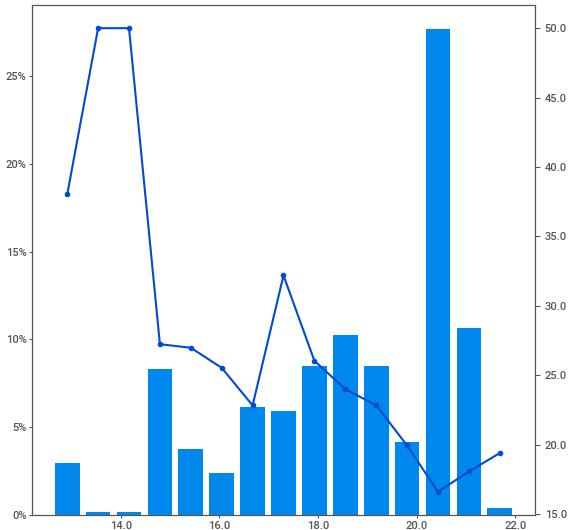
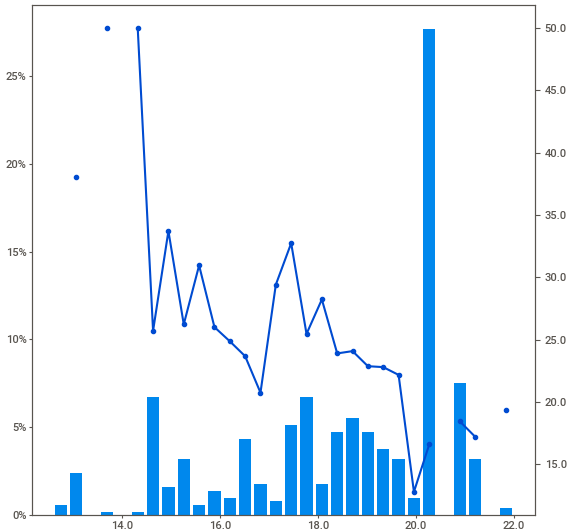
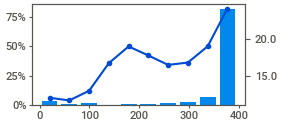
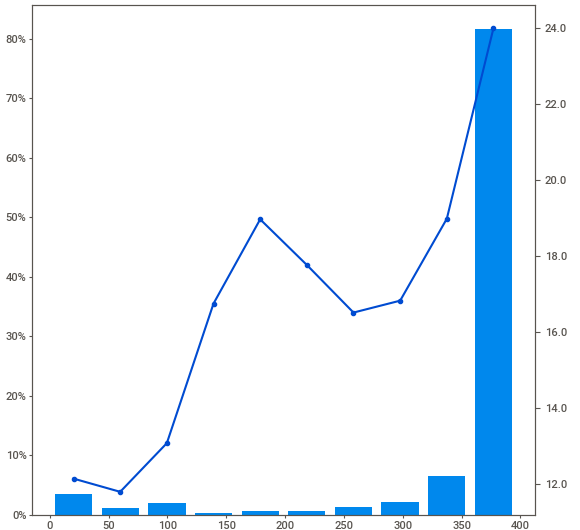
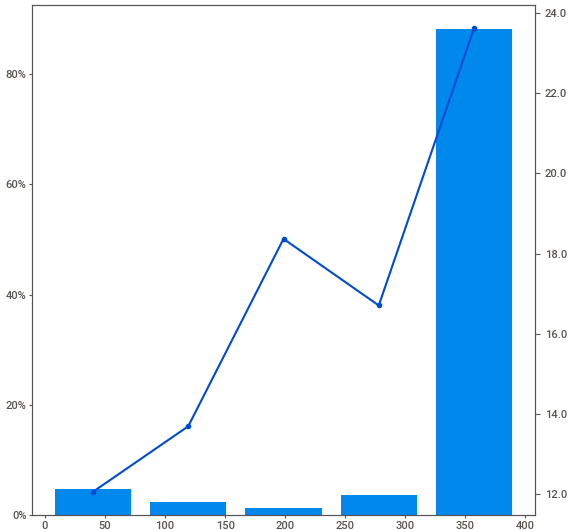
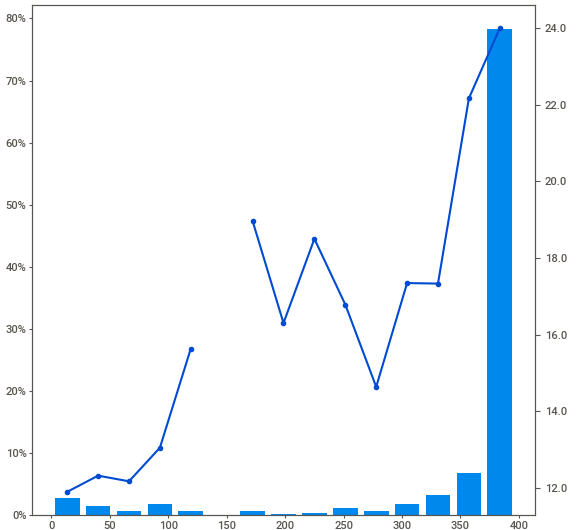
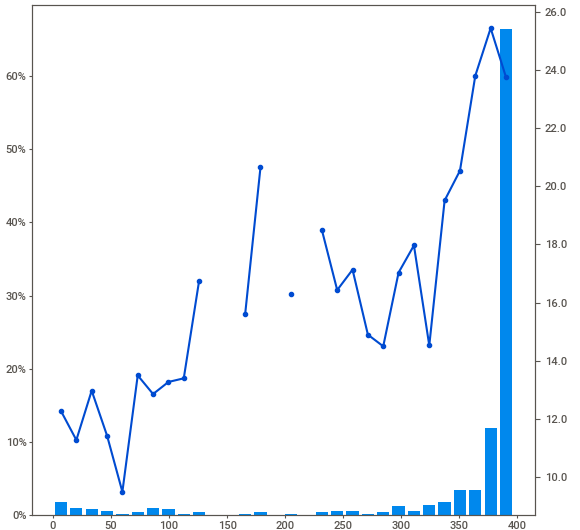
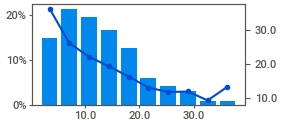
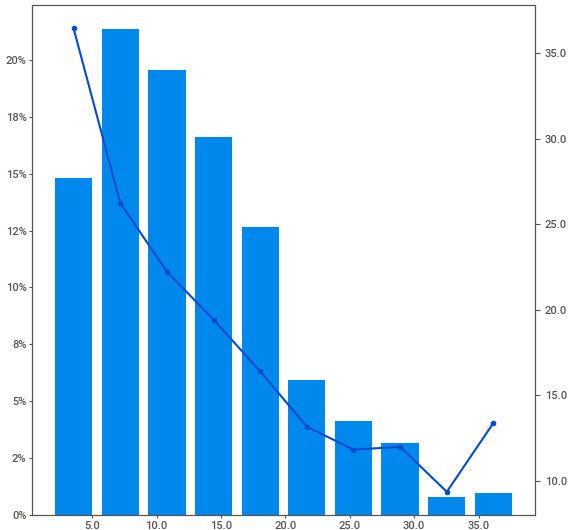
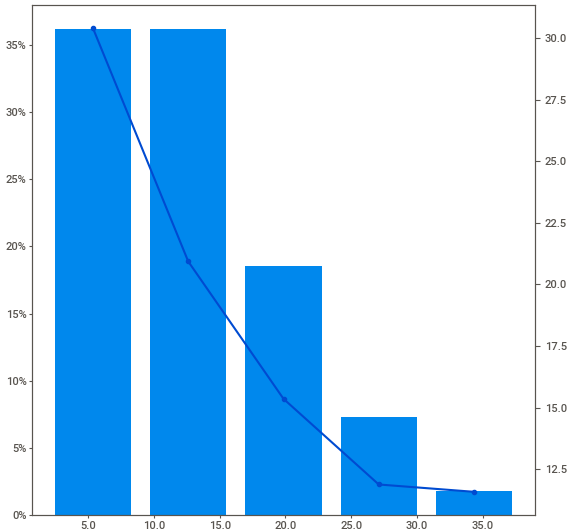
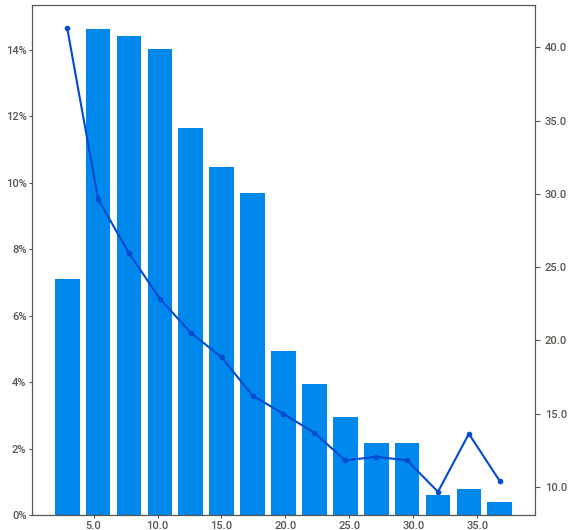
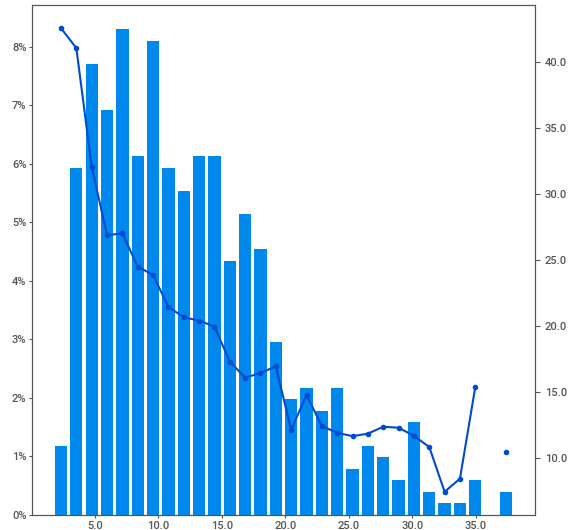
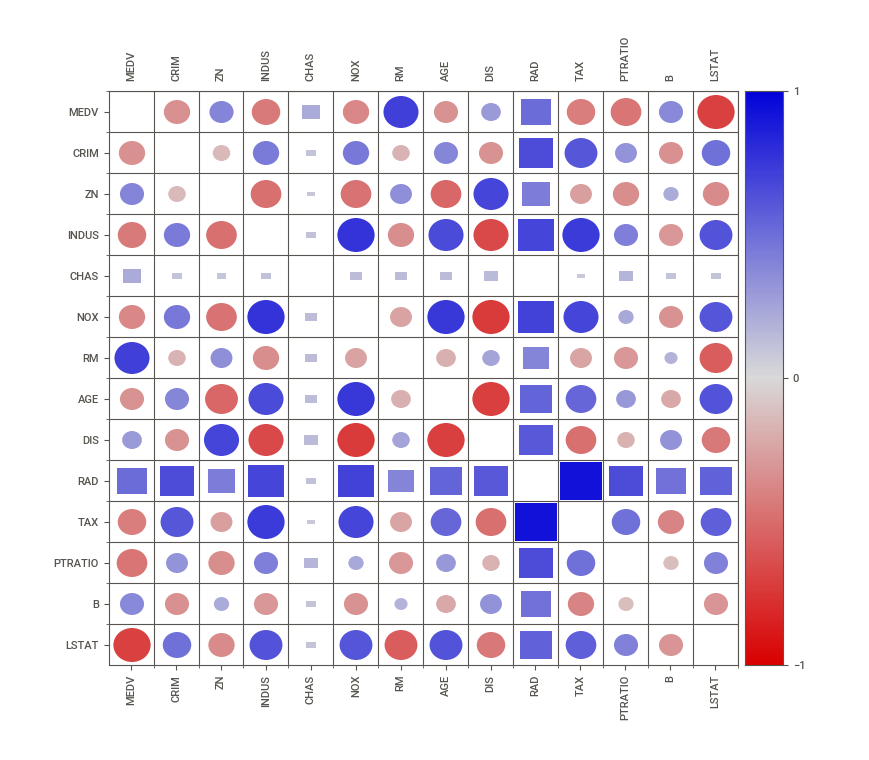
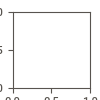

In [ ]:
analysis_report.show_html(filepath='.\\Analysis\\Analysis_report.html')
analysis_report.show_notebook()

<AxesSubplot:>

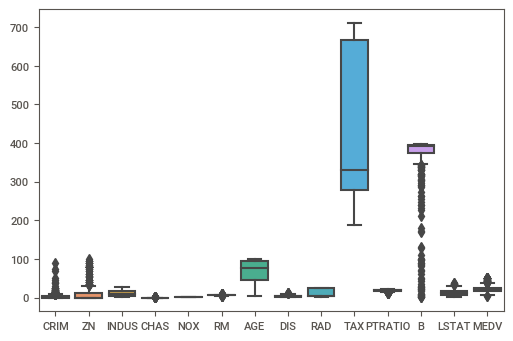

In [ ]:
sns.boxplot(data = x)

In [ ]:
#d.kill()
dtale.instances()

To gain access to an instance object simply pass the value from 'ID' to dtale.get_instance(ID)

ID Name                                       URL
 1      http://DESKTOP-FU5GQEE:40000/dtale/main/1
        http://DESKTOP-FU5GQEE:40000/dtale/main/1
